<a href="https://colab.research.google.com/github/woncoh1/TSAI/blob/main/END2/S3/END2S3A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instruction

1. Write a neural network that can:
    1. take 2 inputs:
        1. an image from MNIST dataset, and
        2. a random number between 0 and 9
    2. and gives two outputs:
        1. the "number" that was represented by the MNIST image, and
        2. the "sum" of this number with the random number that was generated and sent as the input to the network
        3. you can mix fully connected layers and convolution layers
        4. you can use one-hot encoding to represent the random number input as well as the "summed" output. 

2. Your code MUST be:
    1. well documented (via readme file on github and comments in the code)
    2. must mention the data representation
    3. must mention your data generation strategy
    4. must mention how you have combined the two inputs
    5. must mention how you are evaluating your results
    6. must mention "what" results you finally got and how did you evaluate your results
    7. must mention what loss function you picked and why!
    8. training MUST happen on the GPU

3. Once done:
    1. upload the code with short training logs in the readme file from colab to GitHub, and 
    2. share the GitHub link (public repository)


# 0. Setup

1. Library
2. Hyperparameter
3. Option

In [1]:
!python --version

Python 3.7.10


## 0-1 Install Packages

In [2]:
!pip install torchsummary

## 0-2 Load Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from tqdm import tqdm

## 0-3 Define Hyperparameters

In [4]:
# 1-1-1 Download Datasets
mnist_mean = (0.1307,)
mnist_std = (0.3081,)

# 1-1-3 Create Batches
torch.manual_seed(1) # for reproducibility
batch_size = 128
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
gpu_config = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# 1-3-2 Instantiate Optimizer
lr_mnist = 0.01
mo_mnist = 0.90

# 1-3-4 Train Epochs
epochs_mnist = 5

# 1-3-2 Instantiate Optimizer
lr_add = 1e-2 

# 2-1-1 Generate Data
sample_size = 1_000_000 # number of samples
input_dim = 2         # input dimension
output_dim = 1         # output dimension

# 2-3-3 Train Epochs
epochs_add = 100

## 0-4 Set Options

In [5]:
torch.set_printoptions(linewidth=120)

# 1. MNIST

## 1-1 Prepare Data

1. Download and process MNIST dataset
2. Split transformed dataset into training and testing datasets
3. Create batches for training

### 1-1-1 Download Datasets

Download and transform MNIST dataset


In [6]:
def load_dataset(train=False):
    dataset = torchvision.datasets.MNIST(
        root='../data', 
        train=train, 
        download=True,
        transform=transforms.Compose(
            [
             transforms.ToTensor(),
             transforms.Normalize((0.1307,), (0.3081,))
            ]
        )
    )
    return dataset

In [7]:
# split training and testing datasets
train_set = load_dataset(train=True)
test_set = load_dataset(train=False)

### 1-1-2 Inspect Datasets

In [8]:
# size of training set
len(train_set)

60000

In [9]:
# range of label values
train_set.train_labels.min(), train_set.train_labels.max()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


(tensor(0), tensor(9))

In [10]:
# frequency of each label
train_set.train_labels.bincount() 

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [11]:
# sample from the training set
sample = next(iter(train_set))
len(sample), type(sample)

(2, tuple)

In [12]:
# separate image and label from sample
image, label = sample
image.shape, label

(torch.Size([1, 28, 28]), 5)

label: 5


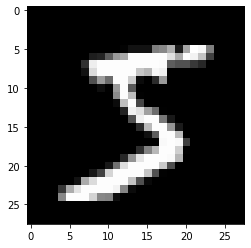

In [13]:
# view image
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

### 1-1-3 Create Batches

Convert training and testing data into batch iterator:
1. Set batch size
2. Shuffle data
3. Configure GPU (if available)

Our workhorse `torch.utils.data.DataLoader` is an iterator which provides all these features:
1. Batching the data
2. Shuffling the data
3.  Loading the data in parallel using multiprocessing workers

In [14]:
def make_batch(dataset):
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size, 
        shuffle=True, 
        **gpu_config,
    )
    return data_loader

In [15]:
train_loader = make_batch(train_set)
test_loader = make_batch(test_set)

### 1-1-4 Inspect Batches

In [16]:
# sample a training batch
batch = next(iter(train_loader))
len(batch), type(batch)

(2, list)

In [17]:
# separate images from labels
images, labels = batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([6, 1, 4, 0, 7, 1, 8, 9, 0, 1, 2, 4, 2, 5, 9, 3, 9, 5, 1, 4, 1, 1, 3, 3, 2, 4, 3, 7, 8, 8, 1, 1, 4, 5, 4, 5, 0,
        1, 0, 0, 7, 3, 7, 5, 0, 4, 1, 5, 3, 7, 9, 4, 6, 2, 6, 8, 5, 1, 5, 0, 0, 0, 3, 9, 9, 2, 4, 9, 2, 0, 3, 6, 5, 1,
        9, 8, 9, 3, 1, 6, 6, 1, 0, 3, 8, 0, 9, 8, 5, 3, 3, 0, 8, 4, 1, 9, 7, 0, 2, 4, 8, 4, 7, 8, 5, 6, 1, 8, 5, 8, 3,
        5, 0, 3, 0, 4, 7, 4, 3, 8, 4, 7, 1, 5, 0, 5, 5, 7])


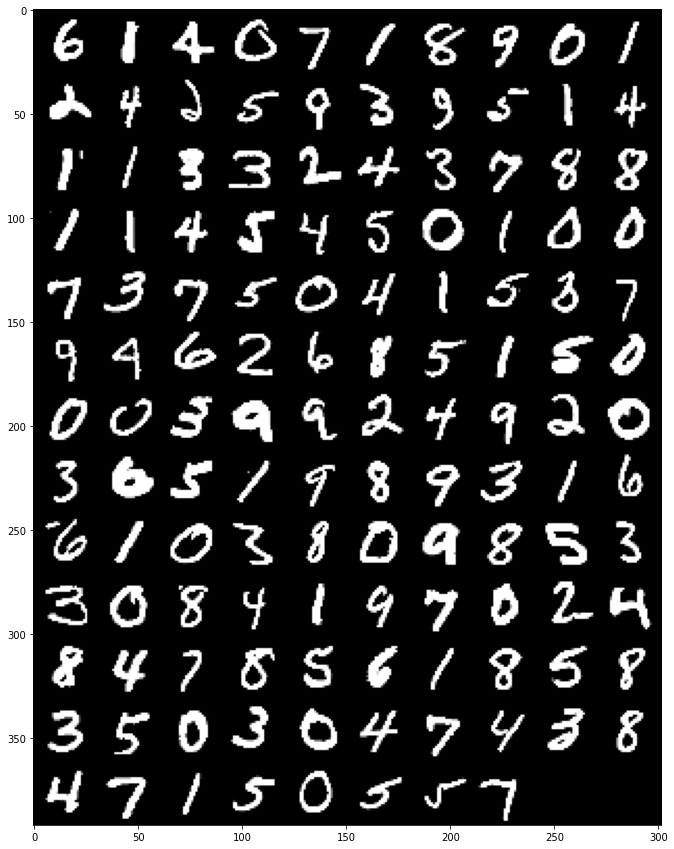

In [18]:
# view grid of images
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

## 1-2 Build Model

1. NN for handwritten digit recognition
2. NN for learning addition of two arbitrary integers within range [0, 9]

### 1-2-1 Define Model

In [19]:
# Define model (neural network) structure
class DigitRecognizer(nn.Module):

    # Parts list describing building blocks
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,              # Dimensions for inputs, kernels, outputs and receptive fields (RF)
                               out_channels=32,            # Format: Width x Height x (# of channels)
                               kernel_size=3,              # Example input dimensions: 28 x 28 x 1
                               padding=1)                  # Input: 28 x 28 x 1   , Kernel: 3 x 3 x 1   , Output: 28 x 28 x 32  , RF: 3  x 3  (RF increases despite padding) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)       # Input: 28 x 28 x 32  , Kernel: 3 x 3 x 32  , Output: 28 x 28 x 64  , RF: 5  x 5   
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Input: 28 x 28 x 64  , Kernel: 2 x 2 x 1   , Output: 14 x 14 x 64  , RF: 10 x 10  
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)      # Input: 14 x 14 x 64  , Kernel: 3 x 3 x 64  , Output: 14 x 14 x 128 , RF: 12 x 12  
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)     # Input: 14 x 14 x 128 , Kernel: 3 x 3 x 128 , Output: 14 x 14 x 256 , RF: 14 x 14  
        self.pool2 = nn.MaxPool2d(2, 2)                    # Input: 7  x 7  x 256 , Kernel: 2 x 2 x 1   , Output: 7  x 7  x 256 , RF: 28 x 28 (no more max-pooling after 7 x 7)
        self.conv5 = nn.Conv2d(256, 512, 3)                # Input: 7  x 7  x 256 , Kernel: 3 x 3 x 256 , Output: 5  x 5  x 512 , RF: 30 x 30  
        self.conv6 = nn.Conv2d(512, 1024, 3)               # Input: 5  x 5  x 512 , Kernel: 3 x 3 x 512 , Output: 3  x 3  x 1024, RF: 32 x 32  
        self.conv7 = nn.Conv2d(1024, 10, 3)                # Input: 3  x 3  x 1024, Kernel: 3 x 3 x 1024, Output: 1  x 1  x 10  , RF: 34 x 34 

    # Step-by-step manual for assembling building blocks 
    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x) # CEO: output should be at least 2 or 3 layers away from information loss (e.g. relu, max-pooling, batch norm, dropout, etc)
        x = x.view(-1, 10) # flatten for softmax
        return F.log_softmax(x, dim=1)

### 1-2-2 Instantiate Model

In [20]:
# Instantiate model into device and view model summary
model_mnist = DigitRecognizer().to(device)
summary(model_mnist, input_size=(1, 28, 28)) # default input size of MNIST dataset

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

## 1-3 Train Model

### 1-3-1 Instantiate Loss

In [21]:
criterion = nn.NLLLoss()

### 1-3-2 Instantiate Optimizer


In [22]:
optimizer = optim.SGD(model_mnist.parameters(), 
                      lr=lr_mnist, 
                      momentum=mo_mnist)

### 1-3-3 Define Trainer

In [23]:
# Optimize model parameters
def train(model: 'neural network', 
          device: 'CPU or GPU', 
          train_loader: 'training batch', 
          optimizer: 'weight-optimizing algorithm'):
    # set model to train mode, enabling features like regularization
    model.train() 
    # use progress meter
    pbar = tqdm(train_loader) 
    # iterate for every batch
    for batch_idx, (data, target) in enumerate(pbar): 
        # instantiate data and target to device
        data, target = data.to(device), target.to(device) 
        
        # zero previously accumulated gradients for mini-batch update
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # define loss function
        loss = criterion(output, target) 
        # calculate gradients 
        loss.backward() 
        # update parameters
        optimizer.step() 
        
        # configure progress meter                                            
        pbar.set_description(desc= f'Loss= {loss.item(): .4f} | Batch ID= {batch_idx}') 

### 1-3-4 Train Epochs

In [24]:
# Bring batches, model, loss function and optimizer together to actually
# carry out training and testing of the model
for epoch in range(epochs_mnist):
    train(model_mnist, device, train_loader, optimizer)

Loss=  0.0654 | Batch ID= 468: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]
Loss=  0.1059 | Batch ID= 468: 100%|██████████| 469/469 [00:18<00:00, 24.93it/s]
Loss=  0.1008 | Batch ID= 468: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
Loss=  0.0470 | Batch ID= 468: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]
Loss=  0.0570 | Batch ID= 468: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]


## 1-4 Test Model

### 1-4-1 Define Tester

In [25]:
# Test how well model parameters are optimized
def test(model, device, test_loader: 'testing batch'):
    # set model to evaluation mode, disabling features like regularization
    model.eval()
    # iteratively accumulate test loss and # of correct predictions
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += criterion(output, target).sum().item()   
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # update # of correct predictions  
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # get average test loss per batch
    test_loss /= len(test_loader.dataset)

    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### 1-4-2 Test Model

In [26]:
test(model_mnist, device, test_loader)


Average loss: 0.0003, Accuracy: 9907/10000 (99%)



In [27]:
images, labels = batch
target = labels[1]
target.item()

1

In [28]:
 input = images[1].unsqueeze(0).to(device)
 output = model_mnist(input)
 prediction = output.argmax(dim=1).squeeze(0)
 prediction.item()

1

# 2. Addition

## 2-1 Prepare Data

### 2-1-1 Generate Data

In [29]:
X = torch.rand(sample_size, input_dim).to(device)        
y = torch.sum(X, axis=-1).reshape(-1, output_dim) 

### 2-1-2 Inspect Data

In [30]:
print(X[0])
print()
print(y)

tensor([0.8207, 0.0614], device='cuda:0')

tensor([[0.8821],
        [0.7485],
        [1.5321],
        ...,
        [1.2935],
        [0.9198],
        [0.8347]], device='cuda:0')


## 2-2 Build Model

### 2-2-1 Define Model

In [31]:
# 3 fully connected layers
model_add = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100), 
    torch.nn.ReLU(),
    torch.nn.Linear(100, output_dim)
    )

### 2-2-2 Instantiate Model

In [32]:
model_add.to(device)
summary(model_add, input_size=(1, 1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 1, 100]             300
              ReLU-2            [-1, 1, 1, 100]               0
            Linear-3            [-1, 1, 1, 100]          10,100
              ReLU-4            [-1, 1, 1, 100]               0
            Linear-5              [-1, 1, 1, 1]             101
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


## 2-3 Train Model

### 2-3-1 Instantiate Loss

In [33]:
criterion = torch.nn.MSELoss()

### 2-3-2 Instantiate Optimizer

In [34]:
optimizer = torch.optim.Adam(model_add.parameters(), lr=lr_add)

### 2-3-3 Train Epochs

In [35]:
for epoch in range(epochs_add):
    y_pred = model_add(X)  # forward step
    loss = criterion(y_pred, y)  # compute loss
    loss.backward()  # backprop (compute gradients)
    optimizer.step()  # update weights (gradient descent step)
    optimizer.zero_grad()  # reset gradients
    if epoch % 10 == 0:
        print(f"Epoch: {epoch+1: <2} | Loss: {loss.item():.6f}")

Epoch: 1  | Loss: 1.144227
Epoch: 11 | Loss: 0.036835
Epoch: 21 | Loss: 0.022791
Epoch: 31 | Loss: 0.007687
Epoch: 41 | Loss: 0.000618
Epoch: 51 | Loss: 0.000258
Epoch: 61 | Loss: 0.000225
Epoch: 71 | Loss: 0.000088
Epoch: 81 | Loss: 0.000050
Epoch: 91 | Loss: 0.000032


## 2-4 Test Model

In [36]:
X_test = 0.1 * torch.randint(low=0, high=10, size=(5, input_dim)).to(device)
X_test

tensor([[0.1000, 0.3000],
        [0.3000, 0.5000],
        [0.0000, 0.0000],
        [0.4000, 0.1000],
        [0.1000, 0.1000]], device='cuda:0')

In [37]:
y_pred = torch.round(10 * model_add(X_test))
y_pred

tensor([[4.],
        [8.],
        [0.],
        [5.],
        [2.]], device='cuda:0', grad_fn=<RoundBackward>)

In [38]:
y_targ = torch.round(10 * torch.sum(X_test, axis=-1).reshape(-1, output_dim))
y_targ

tensor([[4.],
        [8.],
        [0.],
        [5.],
        [2.]], device='cuda:0')

# 3. MNIST + Addition

## 3-1 Build Model

In [39]:
def model_combined(input_image, input_number):
    input_image = input_image.unsqueeze(0).to(device)
    
    input_number = input_number.item()
    input_number *= 0.1 

    output_number = model_mnist(input_image)
    output_number = output_number.argmax(dim=1).squeeze(0)
    output_number = output_number.item()
    output_number *= 0.1

    numbers = torch.tensor([[input_number, output_number]]).to(device)
    sum_total = torch.round(10 * model_add(numbers))

    output_number = int(10 * output_number)
    sum_total = int(sum_total.item())

    return output_number, sum_total

## 3-2 Test Model

In [40]:
def make_randint():
    return torch.randint(low=0, high=10, size=(1,))

def test_combined(model, device, test_loader: 'testing batch'):
    correct = 0
    count = 0

    for batch in test_loader:

        images, labels = batch

        for i in range(len(images)):
            input_image = images[i]
            input_number = make_randint()

            output_number = labels[i]
            target = (output_number.item(), 
                      input_number.item() + output_number.item())
            prediction = model(input_image, input_number)

            correct += target == prediction
            count += 1

    print(f"Accuracy: {correct} / {count} ({100 * correct / count}%)")

In [41]:
test_combined(model_combined, device, test_loader)

Accuracy: 9907 / 10000 (99.07%)
